# Dimensionality Reduction

We will read through this dialogue to understand what PCA is (I apologize that only women are asking questions in the dialogue, which is absolutely sexist)

https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues

Let's see some visualization of PCA here:

https://georgemdallas.wordpress.com/2013/10/30/principal-component-analysis-4-dummies-eigenvectors-eigenvalues-and-dimension-reduction/

https://setosa.io/ev/principal-component-analysis/

So now, let's do that with some real data. We have a bunch of different features. It is likely that some features are better than others and that some features are 'redundant'. Dimensionality reducation with PCA basically takes care of this by figuring out (mathematically) the principle axes (components) whereby our data varies. 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


We will just use the MPG dataset for simplicity

In [2]:
mpg = sns.load_dataset('mpg')

In [3]:
mpg.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino


We are interested in predicting MPG with some of our variables. But let's see if we can reduce the dimensionality first

We are to focus on these variables first

In [26]:
variables = ['weight','displacement','acceleration']

Now, let's visualize our data.

But I'm going to visualize the data in a slightly different way using plotly, which is another plotting library

In [5]:
import plotly.express as px

In [27]:
fig = px.scatter_3d(mpg,mpg['weight'], mpg['displacement'],mpg['acceleration'])
fig.show()

Let's think back to our example in the url above. 

The dimension that is the most spread probably stretches end to end (i.e., like a tube)

Now, let's get our data in the correct format. We are going to turn our dataframe into an array like so

In [28]:
X = mpg[variables]
y = mpg['mpg']

Next, we need to normalize our data. If we don't, then the variance we account for may be soaked by variables that have large values

https://stats.stackexchange.com/questions/69157/why-do-we-need-to-normalize-data-before-principal-component-analysis-pca

We will see this a little later

We will use the StandardScaler, which is basically taking the z-score of the data.

Z-score turns the mean of the distribution to 0 and standard deviation to 1

In [29]:
X_array = StandardScaler().fit_transform(X)
X2 = pd.DataFrame(X_array,columns=X.columns)

We can visualize the new data and it should look the same as our data before transformation

In [31]:
fig = px.scatter_3d(X2, X2['weight'],X2['displacement'],X2['acceleration'],)
fig.show()

Now, to run our PCA, let's import the library

In [10]:
from sklearn.decomposition import PCA

And just like with the other machine learning stuff, we first create an instance of the PCA, then fit the data to it

If we don't specify the number of components, it will just equal the number of features (or, the number of rows if you have more features than rows)

In [32]:
pca = PCA()
x_pca = pca.fit_transform(X2)

Now, we can actually check to see how much of the variance we account for with each eigenvector.

In [33]:
pca.explained_variance_ratio_

array([0.76382345, 0.21758821, 0.01858834])

If you don't normalize, you may find a result like this:

In [34]:
pca_test = PCA()
x_pca_test = pca_test.fit_transform(X)
pca_test.explained_variance_ratio_

array([9.98077682e-01, 1.91561361e-03, 6.70411649e-06])

Wow! So, as expected, that first component basically accounts for most of the variance! and the third component doesn't account for much at all

The first component may be considered our principle component

We can actually visualize our eigenvectors. It helps to turn them into a dataframe

In [35]:
x_pca = pd.DataFrame(x_pca)
x_pca.head()

,0,1,2
0,1.686977,-0.611646,0.213837
1,2.172098,-0.579298,0.344217
2,1.874638,-0.938721,0.299003
3,1.617206,-0.653902,0.248814
4,1.870656,-1.127123,0.153102


Let's just rename them for convenience

In [36]:
x_pca['target']=y
x_pca.columns = ['PC1','PC2','PC3','target']
x_pca.head()

,PC1,PC2,PC3,target
0,1.686977,-0.611646,0.213837,18.0
1,2.172098,-0.579298,0.344217,15.0
2,1.874638,-0.938721,0.299003,18.0
3,1.617206,-0.653902,0.248814,16.0
4,1.870656,-1.127123,0.153102,17.0


Just for fun, we cna check out the eigenvectors (PC) on our data. 

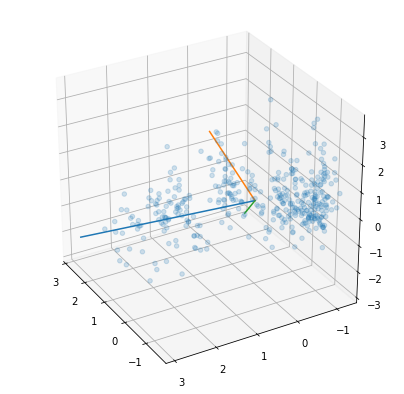

In [39]:
from mpl_toolkits.mplot3d import axes3d    

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

# plot data
ax.scatter(X2['weight'],X2['displacement'], X2['acceleration'], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)

    v0 = pca.mean_
    v1 = pca.mean_ + v

    ax.plot([0,v1[0]],[0,v1[1]],[0,v1[2]])

ax.view_init(30, 150)

We can compare the data with the target. You'll see that the first eigenvector seems related to the target, but the others less so

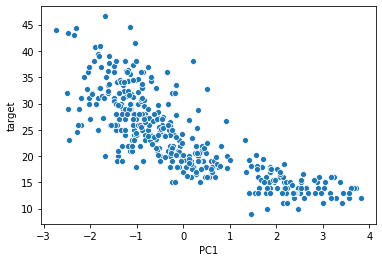

In [40]:
sns.scatterplot(x_pca['PC1'],x_pca['target'])

There are other things you can do with the components. One thing you can do is principal component regression

Basically, we will do regression with our components. And, given that PC1 accounts for so much of the variance, it should do a good job of fitting the data by itself

In [18]:
from sklearn import model_selection

As we learned last week, we will use cross_validation

Note that I'm using ShuffleSplit instead of the default kfold. Since kfold starts folds at the top of the data, if there is any order in your data, it can produce some funky results. 

In [42]:
model = LinearRegression() 
shufflesplit = model_selection.ShuffleSplit(n_splits=100, random_state=0)
results = model_selection.cross_validate(model, x_pca[['PC1']], x_pca['target'],cv=shufflesplit,scoring='r2')
print(results['test_score'].mean())

0.6300782831010528


Cool!

In this particular example, it may not do a better job than, say, "weight" by itself, but this approach is especially useful in more complex datasets!

In [45]:
model = LinearRegression() 
shufflesplit = model_selection.ShuffleSplit(n_splits=100, random_state=0)
#results = model_selection.cross_validate(model, mpg[['weight']], mpg['mpg'],cv=shufflesplit,scoring='r2')
results = model_selection.cross_validate(model, X2[['weight']], y,cv=shufflesplit,scoring='r2')
print(results['test_score'].mean())

0.6805135534291125


PCA is a pretty dense and magical concept. You can do a lot more than what we have discussed here.

For example, 

https://medium.com/@sebastiannorena/pca-principal-components-analysis-applied-to-images-of-faces-d2fc2c083371

https://medium.com/lambda-school-machine-learning/principal-component-analysis-and-what-is-it-really-using-python-8f04dbdb1600